In [1]:
using JuMP
using Ipopt
using DataFrames
import XLSX

abstract type Model end
struct Direct <: Model end
struct Migration <: Model end

In [ ]:
#run = Direct();
run = Migration();

#These two are interdependent in the model and can be included in the future
#a1 = 1/3.4e7 # proportion of migrating squid, where 3.4E7 max(e^(tau-b1))
#K = 1208770.0 # carrying capacity in t
# If you clamp l1, l2, the values of E will be pushed higher.
# These are the only real constants
f = 40.0 # l of fuel per trip
B_h = 7.203 # hours per fisher
B_f = 2.0 # fisher per panga
m = 5492603.58 # cost per unit of transport all boats, MXN/trip
c_t = m*f # fleet cost of transport

### Initial values #############################################################
#Currently not in use
tau0 = 42.0 # temperature
q0 = 0.01 # squid catchability
y_S0 = 0.5 # proportion of migrated squid
R_tt0 = 0.5 # trader cooperation
S0 = 1208770.0 # size of the squid population
E0 = 1.0 # fishing effort
C0 = 120877.0 # squid catch
p_e0 = 164706.0 # max p_e comtrade
p_f0 = 15438.0 # max p_f datamares
R0 = C0*p_f0-(c_t+E0);

In [29]:
#df2 looks at 2001-2016, so df1 should only yield that set too
df1 = DataFrame(XLSX.readtable("./DATA/R3_data.xlsx", "Sheet1")...)
# load columns
y = Int64.(df1[:year][11:26]) #
#pe = Float64.(map(x->ismissing(x) ? NaN : x, df1[:pe_MXNiat][11:26])) #
pf = Float64.(df1[:pf_MXNiat][11:26]) #
#ct = Float64.(map(x->ismissing(x) ? NaN : x, df1[:C_t][11:26])) #
#ssh = Float64.(map(x->ismissing(x) ? NaN : x, df1[:essh_avg][11:26])) #
ml = Float64.(df1[:ML][11:26]) #
ys = map(x->parse(Float64,x),df1[:y_S][11:26]) #


df2 = dropmissing(DataFrame(XLSX.readtable("./DATA/PriceVolDataCorrected.xlsx", "Sheet1")...))
VolAll = Float64.(df2[:tons_DM]) ## CATCH DATA
PrAll = Float64.(df2[:priceMXNia_DM]) ## PRICE DATA 

### New max time
tmax = length(df2[:Year]);

In [ ]:
model = JuMP.Model(solver = IpoptSolver(max_iter=1000,print_frequency_iter=500,sb="yes"));

In [ ]:
@variable(model, b1, start=41.750) # isotherm depth (est)
@variable(model, b2, start=-5.696) # isotherm depth (est)
@variable(model, b3, start=16.397) # isotherm depth (est)
@variable(model, 0.0 <= beta <= 1.0) # slope of demand-price function
@variable(model, 1000.0 <= c_p <= 2148.0) # cost of processing, MXNia/t
@variable(model, 0.0 <= g <= 3.2) # population growth rate
@variable(model, 20000.0 <= gamma <= 51000.0) # maximum demand, t
#@variable(model, h1) # E scale
#@variable(model, h2) # E scale
@variable(model, l1, start = -0.0028) # q scale
@variable(model, l2, start = 0.1667) # q scale
#testing
@variable(model, a1, start=1/3.4e7)
@variable(model, K, start=1208770.0)

@variable(model, 20.0 <= tau[t=1:tmax] <= 80.0) # temperature
@variable(model, 4000.0 <= p_e[t=1:tmax] <= 100_000.0) # export price
@variable(model, q[t=1:tmax]) # catchability squid population
@variable(model, 0.0 <= y_S[t=1:tmax] <= 1.0) # Proportion of squid migration from initial fishing grounds
# c_t is per trip so we need to upscale E hr > fisher > trip
#@variable(model, Escal[t=1:tmax]) # fishing effort
@variable(model, 0.0 <= E[t=1:tmax] <= 1.0) # fishing effort
@variable(model, S[t=1:tmax] >= 0.0) # size of the squid population 18000 , 1200000
@variable(model, C[t=1:tmax]  >= 0.0) # squid catch 10% of S
@variable(model, p_f[t=1:tmax]) # price for fishers
@variable(model, match)

if typeof(run) == Migration
    @variable(model, 11_956_952.0 <= w_m <= 28_108_539.0) # min wage per hour all fleet
    @variable(model, 0.0 <= R_tt[t=1:tmax] <= 1.0) # trader cooperation
    @variable(model, p_min[t=1:tmax] >= 0.0) # minimum wage 28_000_000 NOTE: This is quite low it seems
end

@constraint(model, [t=1:tmax], tau[t] == b1+b2*cos.(t)+b3*sin.(t));
@NLconstraint(model, [t=1:tmax], p_e[t] == gamma*(C[t])^(-beta));
#@NLconstraint(model, [t=1:tmax-1], Escal[t+1] == E[t]+p_f[t]*C[t]-c_t*(E[t]/(B_h+B_f)));
#@constraint(model, [t=1:tmax], E[t] == h1*Escal[t]+h2);
@NLconstraint(model, [t=1:tmax-1], S[t+1] == S[t]+g*S[t]*(1-(S[t]/K))-C[t]);
@NLconstraint(model, [t=1:tmax], C[t] == q[t]*E[t]*S[t]);
@NLconstraint(model, [t=1:tmax], y_S[t] == a1*exp(tau[t]-b1));
@NLconstraint(model, [t=1:tmax], q[t] == l1*tau[t]+l2);
if typeof(run) == Direct
    #First Model
    @constraint(model, [t=1:tmax], p_f[t] == p_e[t]-c_p);
else
    #Second model
    @NLconstraint(model, [t=1:tmax], p_min[t] == (E[t]*w_m)/C[t]);
    @constraint(model, [t=1:tmax], R_tt[t] == 1-y_S[t]);
    @constraint(model, [t=1:tmax], p_f[t] == (p_e[t]-c_p)*(1-R_tt[t])+R_tt[t]*p_min[t]);
end

#@constraint(model, C[1] == VolAll[1]); # squid catch
#@constraint(model, p_f[1] == PrAll[1]); # max p_f datamares
# Initial conditions
#@constraint(model, tau[1] == tau0);  # temperature
#@constraint(model, p_e[1] == p_e0); # max p_e comtrade

#@constraint(model, R_tt[1] == R_tt0); # trader cooperation
#@constraint(model, q[1] == q0); # squid catchability
#@constraint(model, E[1] == E0); # fishing effort
#@constraint(model, S[1] == S0); # size of the squid population

#Minimise the Least Squares differences between our model and the data
@NLconstraint(model, match == sum(abs(p_f[t] - PrAll[t])^2+abs(C[t] - VolAll[t])^2 for t in 1:tmax));
@objective(model, Min, match);

In [ ]:
solve(model)

**TODO:** `ML` and `R` have been removed from the model but ultimately are required outputs.
They should be post-processed vectors.

In [ ]:
using Plots

In [ ]:
ha = plot(y, PrAll, xlabel="Year", ylabel="p_f", label="Data", legend=:bottomright)
plot!(y, getvalue(p_f), label="Model")
hb = plot(y, VolAll, xlabel="Year", ylabel="C", label="Data")
plot!(y, getvalue(C), label="Model")
plot(ha,hb,linewidth=3,layout=(2,1),size=(800,800))

In [ ]:
savefig("migration.png")

In [2]:
using LsqFit
using Plots

In [30]:
modpf(t,p) = p[1]*t.^(-p[2])-p[3]

modpf (generic function with 1 method)

In [31]:
xdata = 1:16
p0 = [30000.0, 0.1, 1500.0]

3-element Array{Float64,1}:
 30000.0
     0.1
  1500.0

In [32]:
fit = curve_fit(modpf, VolAll, PrAll, p0)

LsqFit.LsqFitResult{Float64,1}(13, [81126.8, 0.0505775, 43050.7], [794.067, -639.241, 420.463, 60.2963, 1029.53, 1190.16, 628.803, 598.799, 1541.71, -419.208, -673.878, 511.736, -2300.15, -3751.61, 2685.36, -1656.49], [0.577242 -5.08777e5 -1.0; 0.562989 -5.18793e5 -1.0; … ; 0.688845 -4.11845e5 -1.0; 0.700535 -399925.0 -1.0], false, Float64[])

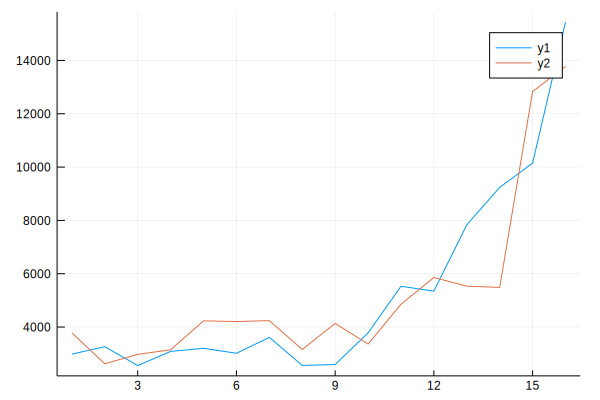

In [33]:
plot(PrAll)
plot!(modpf(VolAll,fit.param))

In [ ]:
fit.param

In [3]:
using CSV
data = CSV.read("DATA/ctd_clean.csv")
year = data[4]
dyear = data[:decimal_year]
d22 = data[:D_22];

In [21]:
# ~Round off~ truncate all data to daily 
# (whilst we can round the date, it's better to truncate here since we'll be taking the mean)
daily = map(date -> trunc(date, Dates.Day), year)

# Generate a vector with no missing timestamps
start = year[1]
finish = year[end]
fulldaily = collect(daily[1]:Dates.Day(1):daily[end])

# And the UT Instant while we're at it (for later)
dfulldaily = map(date -> Dates.value(date), fulldaily)

# Generate a matching vector for d22
fulld22 = fill!(Vector{Float64}(length(fulldaily)), NaN)

# Identify positions of our rounded data in the complete vector
# Since we round, many values will have non-unique indexes
idxinfull = indexin(daily,fulldaily)

# Do work on every unique position
uidxinfull = unique(idxinfull)

for idx in uidxinfull
    # Backport to our rounded data
    position = find(fulldaily[idx] .== daily)
    # Insert mean of collected values into the complete vector,
    # ignoring any missing values in the original dataset.
    vals = collect(skipmissing(d22[position]))
    if length(vals) > 0
        fulld22[idx] = mean(vals)
    end
end;

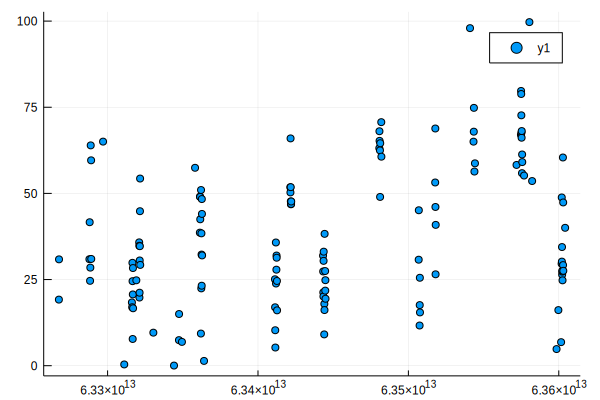

In [22]:
scatter(dfulldaily, fulld22)

In [23]:
temperature(t,p) = p[1]+p[2]*cos.(t)+p[3]*sin.(t)

temperature (generic function with 1 method)

In [28]:
p0 = [41.75, -5.696, 16.397]
fit = curve_fit(temperature, fulld22, dfulldaily, p0)

LoadError: [91mMethodError: no method matching LsqFit.LsqFitResult(::Int64, ::Array{Float64,1}, ::Array{Float64,1}, ::Array{Float64,2}, ::Bool, ::Array{Int64,1})[0m
Closest candidates are:
  LsqFit.LsqFitResult(::Int64, ::Array{T,1}, ::Array{T,1}, ::Array{T,2}, ::Bool, [91m::Array{T,N}[39m) where {T, N} at /home/tim/.julia/v0.6/LsqFit/src/curve_fit.jl:3[39m

In [26]:
typeof(fulld22)

Array{Float64,1}